# Introduction 

This notebook demonstrates my approach to solving the problem of detecting a credit card transaction as fraud or not fraud based on the features that we are given. We use various classification algorithms and also try to hand engineer our data to make it more suitable in order to detect the frauds. 
Before beginning, I would like to thank Janio Martinez Bachmann. Being a starter myself, his kernel was of great help to me and enabled me to explore the data in a much better way. I strongly recommend all of you to check out his kernel as well : https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets?scriptVersionId=16695845

# Understanding our data

The data we are given has 28 features which have undergone PCA. PCA is a dimension reduction algorithm. We assume that are features are scaled as it is a standard practise to scale the features before applying PCA. We cannot really make much sense of our data just by viewing it as after undergoing PCA, the features have been merged and thus we need to find other ways to understand the corelations between differnt features.

# What all do we aim to do ?

*  Understanding the data

*  Preprocess the data 

*  Correlating the data

*  Detecting and Removing Outliers

*  Implementing Random Under-Sampling

*  Building classification models for our under-sampled data

*  Implementing over-sampling using the SMOTE technique

*  Building classification models for our over-sampled data

*  Implementing a simple Neural Networks on our under-sampled and over-sampled dataset

*  Implementing the Isolated Forest Algorithm to detect the fraud cases

*  Implementing certain boosting algorithms to see how they do on our original dataset as well as on the under-sampled dataset

In [1]:
# Importing the libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


> # Loading and Understanding our Data

In [2]:
# Importing the dataset

df = pd.read_csv('../input/creditcard.csv')

# Getting a look at our data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [4]:
# First of all let us check if we have any NULL values in the features that we are given. This is always a good practise to do before we start any problem.
df.isnull().sum().max()

0

**NOTE:** We see that there are no NULL values in our dataset which is a good thing for us as now we do not have to take care of them separately. 

In [5]:
# Checking how skewed our dataset is : 

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**NOTE:** We notice how highly skewed and biased our dataset is. We observe that 99.83% of our dataset is for non-fraud transactions and only about 0.17% are of fraud cases. This can be a problem for us because if we make a classifier which always predicts the transactions as Non-Frauds and we have 100 test cases, still we will be able to get 99.83% accuracy which can make us think that we actually are doing really well. Clearly, this is not the case and hence we will take care of this highly skewed data as well as use some other metrics to test how our classifier is performing.

([<matplotlib.patches.Wedge at 0x7f33bc468358>,
 [Text(-0.006408758506489134, -1.1999828864673054, 'Not Frauds'),
  Text(0.005874640182962571, 1.0999843128893798, 'Frauds')],
 [Text(-0.0037384424621186613, -0.699990017105928, '99.83'),
  Text(0.0032043491907068566, 0.5999914433942071, '0.17')])

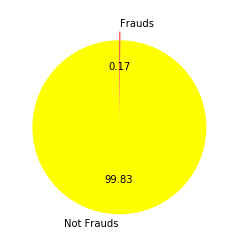

In [6]:
# Visualising how skewed our data is:

explodeTuple = (0.1, 0)
pieLabels = 'Not Frauds', 'Frauds'
figureObject, axesObject = plt.subplots()
colors = ("yellow","red")
shares = [round(df['Class'].value_counts()[0]/len(df) * 100,2),round(df['Class'].value_counts()[1]/len(df) * 100,2) ]
axesObject.pie(shares,explode = explodeTuple,
        colors = colors,

        labels=pieLabels,

        autopct='%1.2f',

        startangle=90)

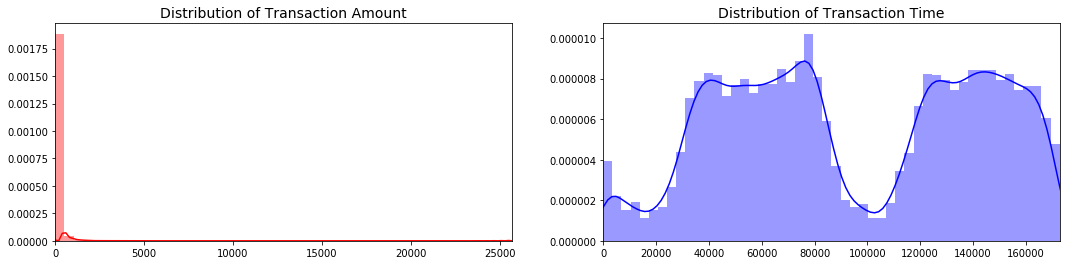

In [7]:
# All our features have been scaled except the time and amount column. Hence, first we plot them to get a better understanding of the distribution of each.

fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()


We have to scale the time and the amount column as well because all the other feautres are aleady scaled and thus by scaling time and amount, we can more effectively use them as a feature.

In [8]:
# Finding the number of fraud cases in our dataset
df['Class'].value_counts()[1]

492

# Creating a sub-sample

**Why do we create a sub-sample?**

* We create a sub-sample to remove the problem of having a highly skewed dataset. We create a sub-sample having 492 randomly selected non-fraud cases and also scaling the time and amount columns for the same. This assures that we have a 50/50 distribution of both the classes in our dataset and assures that our classification algorithm does not become biased. 
* If we do not create a sub-sample, then our model would overfit and assume that in most cases there will not be a fraud. This is particularly bad as we want our model to predict and be certain not to miss out on any fraud cases. Thus, creating a sub-sample helps us in better generalising over both the classes.


In [9]:
# Scaling the time and amount columns
from sklearn.preprocessing import RobustScaler

# We use RobustScaler because it is less prone to outliers.

rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [10]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


# Splitting the original dataset

* Before we proceed to randomly under-sample or over-sample our data, we need to split the original dataset into training and testing dataset. This is because our ultimate goal is to test our classifier on the original dataframe and not on the randomly under-sampled or over-sampled data. Thus, we split our original dataframe into training and testing data.
* We also make sure that both of our datasets have the same percentage of fraud and non-fraud cases, so as to maintain the bias we had in our original dataset.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [     1      4      5 ... 284804 284805 284806] Test: [     0      2      3 ... 284793 284800 284802]
Train: [     0      1      2 ... 284803 284804 284805] Test: [    15     20     23 ... 284792 284795 284806]
Train: [     0      1      2 ... 284802 284804 284806] Test: [     7      9     14 ... 284797 284803 284805]
Train: [     0      1      2 ... 284803 284805 284806] Test: [    11     12     19 ... 284790 284798 284804]
Train: [     0      2      3 ... 284804 284805 284806] Test: [     1      4      5 ... 284794 284799 284801]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]


> Random Under-Sampling

This is a technique in which we randomly remove certain data points so as to maintain a 50/50 ratio of fraud and non-fraud cases. This assures that our classification algorithm is not biased and we are able to better generalise on the given data.

**Steps to implement Random under-sampling :**

1) First, we find the number of fraud cases we have in our dataset. 

2) Then, after finding the number of fraud cases, we make the number of non-fraud cases equal to the number of fraud cases i.e 492 in our case. 

3) After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to shuffle the data to see if our models can maintain a certain accuracy everytime we run this script.

**NOTE:** Although this method does reduce the high biased nature of our dataframe but still it is its own set of problems, the major one being that we loose a lot of information. In our original dataset, we had 2,84,315 non-fraud cases which we have reduced to 492 after applying random under-sampling.

In [12]:
# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)
new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
48054,-0.251520,-0.484240,-0.078270,0.451789,1.136358,-0.195904,0.531992,0.250266,0.498840,-0.023533,...,0.074918,-0.203273,-0.392717,-0.170825,-0.824747,-0.599959,0.463202,-0.057118,-0.088574,0
72757,-0.282401,-0.350639,-2.986466,-0.000891,0.605887,0.338338,0.685448,-1.581954,0.504206,-0.233403,...,-0.764274,-0.875146,-0.509849,1.313918,0.355065,0.448552,0.193490,1.214588,-0.013923,1
237380,-0.218543,0.758033,-0.367926,1.091107,0.127558,-0.901631,0.820510,-1.411047,1.271461,-0.238172,...,-0.257785,0.255654,0.735540,-0.441265,-0.124962,0.230076,-0.212903,0.112636,0.160720,0
149577,-0.293440,0.080006,0.007379,2.365183,-2.600287,1.111602,3.276441,-1.776141,2.114531,-0.830084,...,-0.006388,-0.563944,-0.902100,-0.404382,-0.012944,0.589836,-0.734449,-0.447529,-0.362375,1
27627,-0.042479,-0.588094,0.333499,1.699873,-2.596561,3.643945,-0.585068,-0.654659,-2.275789,0.675229,...,0.329342,0.469212,-0.144363,-0.317981,-0.769644,0.807855,0.228164,0.551002,0.305473,1


># Correlating the data

([<matplotlib.patches.Wedge at 0x7f33b854fc18>,
 [Text(-1.2000000000000002, 1.469576158976824e-16, 'Not Frauds'),
  Text(1.1, -2.6942229581241775e-16, 'Frauds')],
 [Text(-0.7, 8.572527594031472e-17, '50.00'),
  Text(0.6, -1.4695761589768238e-16, '50.00')])

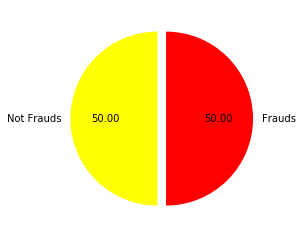

In [13]:
# Seeing the equally balanced distribution of classes

explodeTuple = (0.1, 0)
pieLabels = 'Not Frauds', 'Frauds'
figureObject, axesObject = plt.subplots()
colors = ("yellow","red")
shares = [round(new_df['Class'].value_counts()[0]/len(new_df) * 100,2),round(new_df['Class'].value_counts()[1]/len(new_df) * 100,2) ]
axesObject.pie(shares,explode = explodeTuple,
        colors = colors,

        labels=pieLabels,

        autopct='%1.2f',

        startangle=90)

> # Correlation Matrcies

* Correlation matrcies basically help us in understanding the various patterns between different features and the fraud cases. In our particular case, the correlation matrices are of great importance because we do not actually know what the 28 features in our input dataset represnt. Thus, by observing the correlations between different features and fraud class, we are able to identify the positive and negative correlations between them. 
* There are 2 types of correlations : 
1. Positive Correlaions: These are the features for which higher value tend to point towards a fraud transaction.
2. Negative Correlations: These are the features for which lower values tend to point towards a fraud transaction.

**NOTE**: We visualise the correlations on our balanced dataset because otherwise our correlations will be affected by the highly biased and skewed dataset that we have for a particular(non-fraud) class.

In [14]:
# Creating the correlation matrix

corr_matrix = new_df.corr()
print(corr_matrix["Class"].sort_values(ascending=False))

Class            1.000000
V4               0.704510
V11              0.686287
V2               0.493886
V19              0.301262
V20              0.146485
V21              0.128246
V27              0.095432
V8               0.067089
scaled_amount    0.056113
V26              0.050382
V25              0.034892
V28              0.022353
V22             -0.002413
V13             -0.035344
V23             -0.045243
V15             -0.072933
V24             -0.093313
scaled_time     -0.168791
V5              -0.374496
V6              -0.416107
V1              -0.432298
V18             -0.468828
V7              -0.473034
V9              -0.546906
V17             -0.559851
V3              -0.565573
V16             -0.592749
V10             -0.625848
V12             -0.680938
V14             -0.751856
Name: Class, dtype: float64


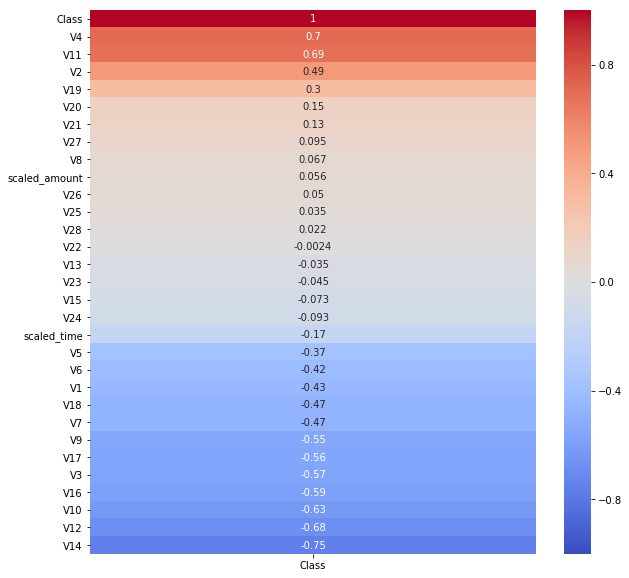

In [15]:
# Visualising the correlation matrix using a heatmap

plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix[['Class']].sort_values(by=['Class'],ascending=False),
            vmin=-1,
            cmap='coolwarm',
            annot=True);

# Observed Correlations :

* Negative Correlations : 
1. V14
2. V12
3. V10
4. V16


* Positive Correlations :
1. V4
2. V11

> # Anamoly Detection and Outlier Detection

* We try to remove the extreme outliers because having extreme outliers in our dataset can cause the classification to divert from the general trend because during the training process, it tries hard to classify the outliers correctly which does not help in the longer run.
* We remove the outliers that are present in classes that have strong correlations with our class feature. We do so because these are the features which highly affect our output and hence having outliers in these features makes our algorithm less robust to generalise.

> # Interquartile Range Method

**Interquartile Range (IQR)**: We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.

* We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect. 
* **The Tradeoff**: The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.

In [16]:
# Finding the index of all the outliers

# 1) V14
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
v14_q1, v14_q3 = np.percentile(v14_fraud, [25, 75])
v14_iqr = v14_q3 - v14_q1
v14_lower_bound = v14_q1 - (1.5 * v14_iqr)
v14_upper_bound = v14_q3 + (1.5 * v14_iqr)
outliers_v14 = [x for x in v14_fraud if x < v14_lower_bound or x > v14_upper_bound]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers_v14)))
print('V14 outliers:{}'.format(outliers_v14))
outliers_index_v14 = []
for i in range(len(v14_fraud)):
    if v14_fraud[i] < v14_lower_bound or v14_fraud[i] > v14_upper_bound:
        outliers_index_v14.append(i)
print(outliers_index_v14)   
print('----' * 28)

# 2) V12
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
v12_q1, v12_q3 = np.percentile(v12_fraud, [25, 75])
v12_iqr = v12_q3 - v12_q1
v12_lower_bound = v12_q1 - (1.5 * v12_iqr)
v12_upper_bound = v12_q3 + (1.5 * v12_iqr)
outliers_v12 = [x for x in v12_fraud if x < v12_lower_bound or x > v12_upper_bound]
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers_v12)))
print('V12 outliers:{}'.format(outliers_v12))
outliers_index_v12 = []
for i in range(len(v12_fraud)):
    if v12_fraud[i] < v12_lower_bound or v12_fraud[i] > v12_upper_bound:
        outliers_index_v12.append(i)
print(outliers_index_v12) 
print('----' * 28)

# 3) V10
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
v10_q1, v10_q3 = np.percentile(v10_fraud, [25, 75])
v10_iqr = v10_q3 - v10_q1
v10_lower_bound = v10_q1 - (1.5 * v10_iqr)
v10_upper_bound = v10_q3 + (1.5 * v10_iqr)
outliers_v10 = [x for x in v10_fraud if x < v10_lower_bound or x > v10_upper_bound]
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers_v10)))
print('V10 outliers:{}'.format(outliers_v10))
outliers_index_v10 = []
for i in range(len(v10_fraud)):
    if v10_fraud[i] < v10_lower_bound or v10_fraud[i] > v10_upper_bound:
        outliers_index_v10.append(i)
print(outliers_index_v10) 
print('----' * 28)

# 4) V11
v11_fraud = new_df['V11'].loc[new_df['Class'] == 1].values
v11_q1, v11_q3 = np.percentile(v11_fraud, [25, 75])
v11_iqr = v11_q3 - v11_q1
v11_lower_bound = v11_q1 - (1.5 * v11_iqr)
v11_upper_bound = v11_q3 + (1.5 * v11_iqr)
outliers_v11 = [x for x in v11_fraud if x < v11_lower_bound or x > v11_upper_bound]
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers_v11)))
print('V11 outliers:{}'.format(outliers_v11))
outliers_index_v11 = []
for i in range(len(v11_fraud)):
    if v11_fraud[i] < v11_lower_bound or v11_fraud[i] > v11_upper_bound:
        outliers_index_v11.append(i)
print(outliers_index_v11)  
print('----' * 28)

Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.4937733551053, -19.2143254902614, -18.8220867423816, -18.049997689859396]
[144, 148, 166, 239]
----------------------------------------------------------------------------------------------------------------
Feature V12 Outliers for Fraud Cases: 6
V12 outliers:[-18.553697009645802, -17.7691434633638, -17.631606313870698, -18.4311310279993, -18.683714633344298, -18.047596570821604]
[6, 148, 166, 253, 329, 450]
----------------------------------------------------------------------------------------------------------------
Feature V10 Outliers for Fraud Cases: 19
V10 outliers:[-15.563791338730098, -18.2711681738888, -17.141513641289198, -22.1870885620007, -15.563791338730098, -24.403184969972802, -19.836148851696, -24.5882624372475, -18.9132433348732, -22.1870885620007, -20.949191554361104, -22.1870885620007, -16.3035376590131, -16.2556117491401, -16.6011969664137, -16.6496281595399, -16.7460441053944, -22.1870885620007, -23.228254

In [17]:
# Merging all the outliers index list into one list:

merged_list = outliers_index_v14 + outliers_index_v10 + outliers_index_v12 + outliers_index_v11

# Function to find the unique index from te merged list:

def unique(merged_list): 
      
    # insert the list to the set 
    list_set = set(merged_list) 
    # convert the set to the list 
    unique_list = (list(list_set)) 
    for x in unique_list: 
        print(x)
    return unique_list    

unique_list = unique(merged_list)    

133
6
394
140
13
144
274
148
410
285
34
290
36
166
38
314
447
448
194
323
196
450
329
201
462
85
215
351
96
108
239
121
253


In [18]:
# Removing the outiers

for i in range(len(unique_list)):
    new_df.drop(new_df.index[unique_list[i]], inplace = True)

In [19]:
new_df.shape

(951, 31)

> # Applying t-SNE algorithm:

We appl the t-SNE algorithm to get a visual sense of the data that is given to us. It is a clustering algorithm that first reduces the dimensions of our data into a plottable form and then forms clusters.


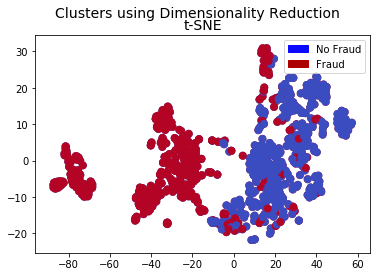

In [20]:
# Applying t-SNE

X = new_df.drop('Class', axis=1)
y = new_df['Class']
blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
plt.suptitle('Clusters using Dimensionality Reduction', fontsize=14)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
plt.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
plt.title('t-SNE', fontsize=14)
plt.legend(handles=[blue_patch, red_patch])
plt.show()

> # Development of Models:

* First, we test out various classfication models on our randomly under-sampled data.
* Second, we test out various classification models on our Over-Sampled data that we create using the SMOTE technique.
* Third, we test out the Isolated Forest algorithm on our original dataset.
* Fourth, we test out the various boosting algorithms on both our original dataset as well as on the under-sampled data

> # Classification models on our Randomly Under-Sampled Data:

We test out various classification models on our randomly under-sampled data. We build a model using each of the following algorithms:
* Logistic Regression
* KNearestNeighbors
* Support Vetor Machines
* Decision Tree Classifier
* Random Forest Classifier
* Naive Bayes Classifier


In [21]:
from sklearn.model_selection import train_test_split

# Dividing the dataset nto X and y
X = new_df.drop('Class', axis=1)
y = new_df['Class']

# Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [23]:
# Implementing the classifiers(with their default parameters):

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier()
}

In [24]:
# Finding the cross_val score for our simple default classification algorithms:

from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", training_score.mean() * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 94.4718503179127 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.76214982333123 % accuracy score
Classifiers:  SVC Has a training score of 93.15603806295378 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 90.7867456265648 % accuracy score
Classifiers:  RandomForestClassifier Has a training score of 93.02187913622518 % accuracy score


In [25]:
# Using GridSearchCV to find the best parameters for our classification models:

from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)

# Logistic Regression best classifier
log_reg = grid_log_reg.best_estimator_
print(grid_log_reg.best_params_)
print("-" * 115)

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)

# KNears best estimator
knears_neighbors = grid_knears.best_estimator_
print(grid_knears.best_params_)
print("-" * 115)

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_
print(grid_svc.best_params_)
print("-" * 115)

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# Tree best estimator
tree_clf = grid_tree.best_estimator_
print(grid_tree.best_params_)
print("-" * 115)

# Random Forest Classifier
forest_params = {"n_estimators":[10, 100], "criterion":["gini", "entropy"], "min_samples_split":list(range(2, 5, 1))}
grid_forest = GridSearchCV(RandomForestClassifier(), forest_params)
grid_forest.fit(X_train, y_train)

# Forest best estimator
forest_clf = grid_forest.best_estimator_
print(grid_forest.best_params_)

{'C': 1, 'penalty': 'l1'}
-------------------------------------------------------------------------------------------------------------------
{'algorithm': 'ball_tree', 'n_neighbors': 2}
-------------------------------------------------------------------------------------------------------------------
{'C': 0.5, 'kernel': 'linear'}
-------------------------------------------------------------------------------------------------------------------
{'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 5}
-------------------------------------------------------------------------------------------------------------------
{'criterion': 'entropy', 'min_samples_split': 3, 'n_estimators': 100}


In [26]:
# Now let us see the cross_val score of our best models that we found using the GridSearchCV:

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv = 5)
print("Best Logistic Regression model has a cross-validation score of ",log_reg_score.mean() * 100, "on the training set")

knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv = 5)
print("Best KNearest Neighbors model has a cross-validation score of ", knears_score.mean() * 100, "on the training set")

svc_score = cross_val_score(svc, X_train, y_train, cv = 5)
print("Best SVC model has a cross-validation score of ", svc_score.mean() * 100, "on the training set")

tree_score = cross_val_score(tree_clf, X_train, y_train, cv = 5)
print("Best DecisionTree model has a cross-validation score of ", tree_score.mean() * 100, "on the training set")

forest_score = cross_val_score(forest_clf, X_train, y_train, cv = 5)
print("Best RandomForest model has a cross-validation score of ", forest_score.mean() * 100, "on the training set")

Best Logistic Regression model has a cross-validation score of  94.33855138430415 on the training set
Best KNearest Neighbors model has a cross-validation score of  92.76300981645127 on the training set
Best SVC model has a cross-validation score of  94.60082650464624 on the training set
Best DecisionTree model has a cross-validation score of  93.29368252471198 on the training set
Best RandomForest model has a cross-validation score of  94.60344065591846 on the training set


In [27]:
# Now, we also find the cross-validation score on the testing data because we want our model to do well on both the training as well as the testing data:

log_reg_score_test = cross_val_score(log_reg, X_test, y_test, cv = 5)
print("Best Logistic Regression model has a cross-validation score of ",log_reg_score_test.mean() * 100, "on the testing set")

knears_score_test = cross_val_score(knears_neighbors, X_test, y_test, cv = 5)
print("Best KNearest Neighbors model has a cross-validation score of ", knears_score_test.mean() * 100, "on the testing set")

svc_score_test = cross_val_score(svc, X_test, y_test, cv = 5)
print("Best SVC model has a cross-validation score of ", svc_score_test.mean() * 100, "on the testing set")

tree_score_test = cross_val_score(tree_clf, X_test, y_test, cv = 5)
print("Best DecisionTree model has a cross-validation score of ", tree_score_test.mean() * 100, "on the testing set")

forest_score_test = cross_val_score(forest_clf, X_test, y_test, cv = 5)
print("Best RandomForest model has a cross-validation score of ", forest_score_test.mean() * 100, "on the testing set")

Best Logistic Regression model has a cross-validation score of  88.4885290148448 on the testing set
Best KNearest Neighbors model has a cross-validation score of  90.59379217273953 on the testing set
Best SVC model has a cross-validation score of  87.96221322537112 on the testing set
Best DecisionTree model has a cross-validation score of  85.34412955465586 on the testing set
Best RandomForest model has a cross-validation score of  91.12010796221321 on the testing set


In [28]:
# Finding the accuracy score on the original testing dataset:

log_reg_score_test_orig = cross_val_score(log_reg, original_Xtest, original_ytest, cv = 2)
print("Best Logistic Regression model has a cross-validation score of ",log_reg_score_test_orig.mean() * 100, "on the testing set")

knears_score_test_orig = cross_val_score(knears_neighbors, original_Xtest, original_ytest, cv = 2)
print("Best KNearest Neighbors model has a cross-validation score of ", knears_score_test_orig.mean() * 100, "on the testing set")

svc_score_test_orig = cross_val_score(svc, original_Xtest, original_ytest, cv = 2)
print("Best SVC model has a cross-validation score of ", svc_score_test_orig.mean() * 100, "on the testing set")

tree_score_test_orig = cross_val_score(tree_clf, original_Xtest, original_ytest, cv = 2)
print("Best DecisionTree model has a cross-validation score of ", tree_score_test_orig.mean() * 100, "on the testing set")

forest_score_test_orig = cross_val_score(forest_clf, original_Xtest, original_ytest, cv = 2)
print("Best RandomForest model has a cross-validation score of ", forest_score_test_orig.mean() * 100, "on the testing set")

Best Logistic Regression model has a cross-validation score of  99.89290884441392 on the testing set
Best KNearest Neighbors model has a cross-validation score of  99.89466477060007 on the testing set
Best SVC model has a cross-validation score of  99.90344255227909 on the testing set
Best DecisionTree model has a cross-validation score of  99.88588698892106 on the testing set
Best RandomForest model has a cross-validation score of  99.91924311407685 on the testing set


In [29]:
# Now let us plot the learning curve for our classifiers:

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # Logistic Regression Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # KNearestNeighbors Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # SVC Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Decision Tree Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size ')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    
    return plt

def plot_learning_curve2(estimator, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, (ax1) = plt.subplots(1, 1, figsize=(10,7), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # Random Forest Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.set_title("Random Forest Classifier Learning Curve", fontsize = 14)
    ax1.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

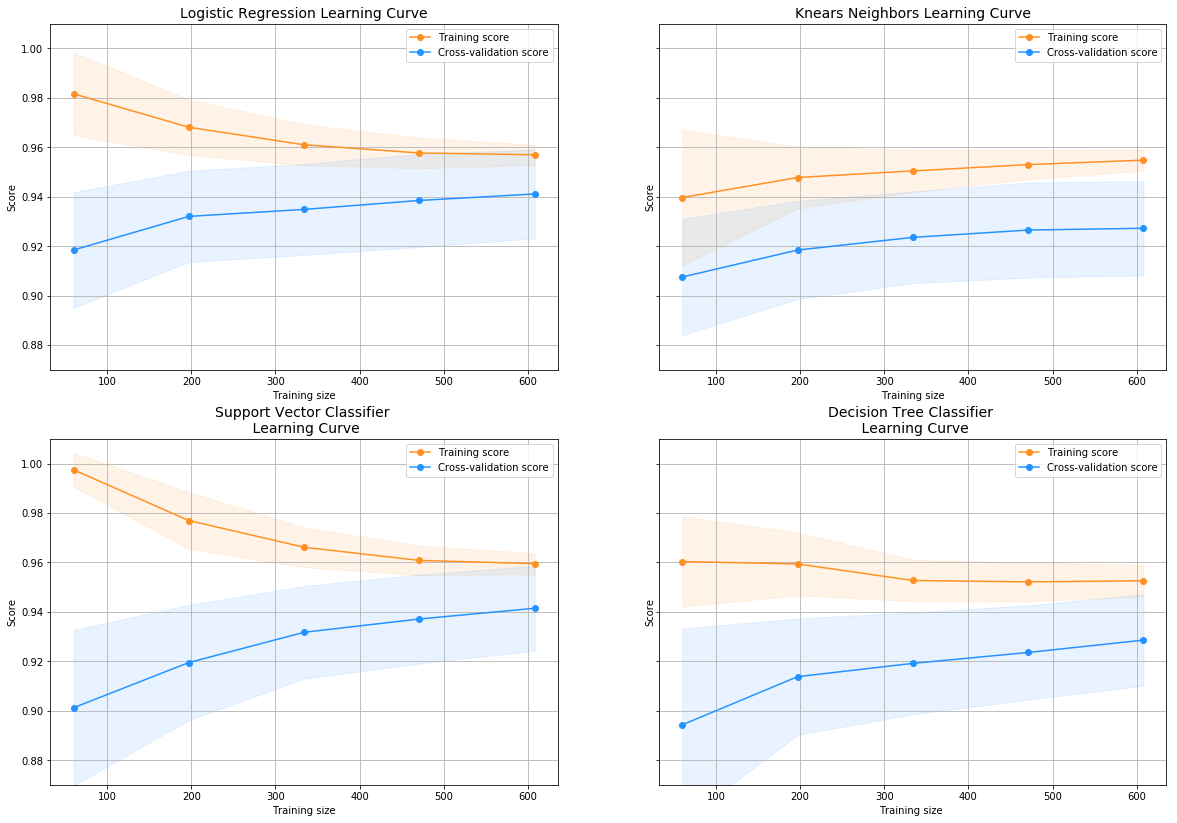

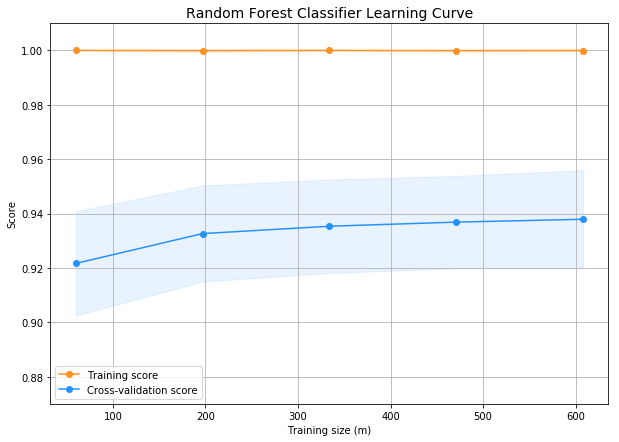

In [30]:
# Plotting the learning curves:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=-1)
plot_learning_curve2(forest_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=-1)

> # ROC Curve

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate
False Positive Rate
True Positive Rate (TPR) is a synonym for recall and is therefore defined as follows:

 
False Positive Rate (FPR) is defined as follows:

 
An ROC curve plots TPR vs. FPR at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives.

# NOTE: We use ROC curves when we have a balanced datasets.

In [31]:
# First, lets save all the predictions that our best classifiers make for the training set

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

forest_pred = cross_val_predict(forest_clf, X_train, y_train, cv = 5)

In [32]:
# Finding the roc_auc scores:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Random Forest Classifier: ', roc_auc_score(y_train, forest_pred))

Logistic Regression:  0.9765995609387877
KNears Neighbors:  0.9277799707754208
Support Vector Classifier:  0.9777145271089135
Decision Tree Classifier:  0.9277384192411304
Random Forest Classifier:  0.9409102556111884


In [33]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

cross_val = KFold(n_splits=3, random_state=42)
scores1 = cross_val_score(log_reg, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Logistic Regression: ", scores1.mean())
scores2 = cross_val_score(knears_neighbors, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - KNears Neigbors: ", scores2.mean())
scores3 = cross_val_score(svc, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - SVC: ", scores3.mean())
scores4 = cross_val_score(tree_clf, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Decision Tree: ", scores4.mean())
scores5 = cross_val_score(forest_clf, X_train, y_train, cv=cross_val, scoring='roc_auc')
print("Mean AUC Score - Random Forest: ", scores5.mean())

Mean AUC Score - Logistic Regression:  0.9755171024208401
Mean AUC Score - KNears Neigbors:  0.9507823512414757
Mean AUC Score - SVC:  0.9764026401229469
Mean AUC Score - Decision Tree:  0.9561723209133435
Mean AUC Score - Random Forest:  0.9776666721442346


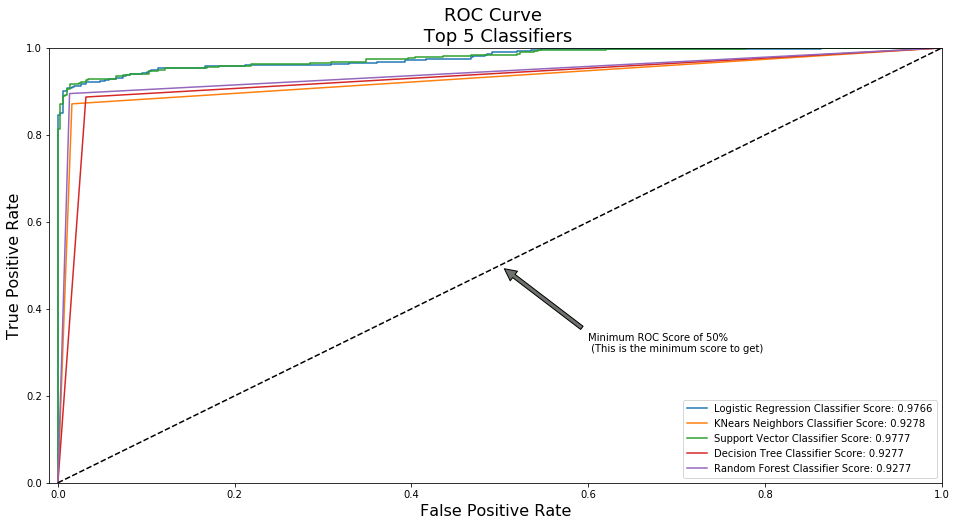

In [34]:
# Plotting the ROC curve:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)
forest_fpr, forest_tpr, forest_threshold = roc_curve(y_train, forest_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, forest_fpr, forest_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 5 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(forest_fpr, forest_tpr, label = 'Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr, forest_fpr, forest_tpr)
plt.show()

> # Precision - Recall Curve

Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. In information retrieval, precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned.
The precision-recall curve shows the tradeoff between precision and recall for different threshold. A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall).

Precision (P) is defined as the number of true positives (Tp) over the number of true positives plus the number of false positives (Fp).

**P = Tp/Tp+Fp**

Recall (R) is defined as the number of true positives (Tp) over the number of true positives plus the number of false negatives (Fn).

**R = Tp/Tp+Fn**

These quantities are also related to the (F1) score, which is defined as the harmonic mean of precision and recall.

**F1 score = 2*P*R/P+R**

# NOTE: We use precision-recall curves for unbalanced datasets.

In [35]:
# We first find the predictions of our best classifiers on the original test dataset because ultimately that is the one that we want to do well on. Also, it is unbalanced.

y_score_log_reg = cross_val_predict(log_reg, original_Xtest, original_ytest, cv=2,
                             method="decision_function")

y_score_knears = cross_val_predict(knears_neighbors, original_Xtest, original_ytest, cv=2)

y_score_svc = cross_val_predict(svc, original_Xtest, original_ytest, cv=2,
                             method="decision_function")

y_score_tree = cross_val_predict(tree_clf, original_Xtest, original_ytest, cv=2)

y_score_forest = cross_val_predict(forest_clf, original_Xtest, original_ytest, cv = 2)

In [36]:
from sklearn.metrics import average_precision_score

average_precision_log_reg = average_precision_score(original_ytest, y_score_log_reg)
print('Average precision-recall score for Logistic Regression: {0:0.2f}'.format(average_precision_log_reg))

average_precision_knears = average_precision_score(original_ytest, y_score_knears)
print('Average precision-recall score for KNears Neighbors: {0:0.2f}'.format(average_precision_knears))

average_precision_svc = average_precision_score(original_ytest, y_score_svc)
print('Average precision-recall score for SVC: {0:0.2f}'.format(average_precision_svc))

average_precision_tree = average_precision_score(original_ytest, y_score_tree)
print('Average precision-recall score for Decision Tree: {0:0.2f}'.format(average_precision_tree))

average_precision_forest = average_precision_score(original_ytest, y_score_forest)
print('Average precision-recall score for Random Forest: {0:0.2f}'.format(average_precision_forest))

Average precision-recall score for Logistic Regression: 0.62
Average precision-recall score for KNears Neighbors: 0.45
Average precision-recall score for SVC: 0.62
Average precision-recall score for Decision Tree: 0.41
Average precision-recall score for Random Forest: 0.59


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score for Decision Tree ')

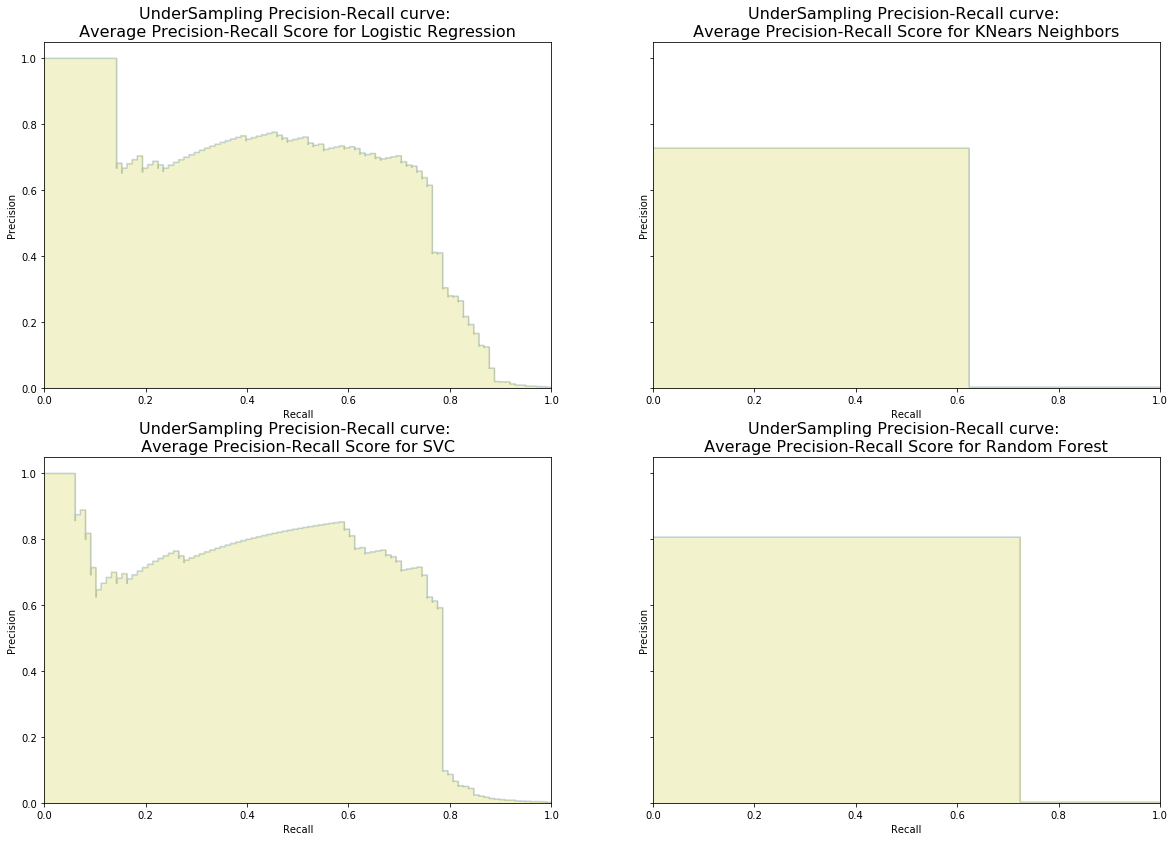

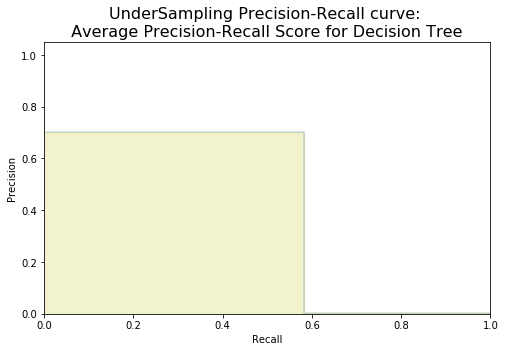

In [37]:
from sklearn.metrics import precision_recall_curve
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
precision_log_reg, recall_log_reg, _ = precision_recall_curve(original_ytest, y_score_log_reg)

ax1.step(recall_log_reg, precision_log_reg, color='#004a93', alpha=0.2,
         where='post')
ax1.fill_between(recall_log_reg, precision_log_reg, step='post', alpha=0.2,
                 color='y')

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score for Logistic Regression ', fontsize=16)

precision_knears, recall_knears, _ = precision_recall_curve(original_ytest, y_score_knears)

ax2.step(recall_knears, precision_knears, color='#004a93', alpha=0.2,
         where='post')
ax2.fill_between(recall_knears, precision_knears, step='post', alpha=0.2,
                 color='y')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([0.0, 1.0])
ax2.set_title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score for KNears Neighbors ', fontsize=16)

precision_svc, recall_svc, _ = precision_recall_curve(original_ytest, y_score_svc)

ax3.step(recall_svc, precision_svc, color='#004a93', alpha=0.2,
         where='post')
ax3.fill_between(recall_svc, precision_svc, step='post', alpha=0.2,
                 color='y')

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_ylim([0.0, 1.05])
ax3.set_xlim([0.0, 1.0])
ax3.set_title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score for SVC ', fontsize=16)

precision_forest, recall_forest, _ = precision_recall_curve(original_ytest, y_score_forest)

ax4.step(recall_forest, precision_forest, color='#004a93', alpha=0.2,
         where='post')
ax4.fill_between(recall_forest, precision_forest, step='post', alpha=0.2,
                 color='y')

ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_ylim([0.0, 1.05])
ax4.set_xlim([0.0, 1.0])
ax4.set_title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score for Random Forest ', fontsize=16)

f, (ax1) = plt.subplots(1, 1, figsize=(8,5), sharey=True)
precision_tree, recall_tree, _ = precision_recall_curve(original_ytest, y_score_tree)

ax1.step(recall_tree, precision_tree, color='#004a93', alpha=0.2,
         where='post')
ax1.fill_between(recall_tree, precision_tree, step='post', alpha=0.2,
                 color='y')

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score for Decision Tree ', fontsize=16)



> # Confusion Matrix 

* A confusion matrix is a table that is often used to describe the performance of a classification model (or “classifier”) on a set of test data for which the true values are known.
* It allows easy identification of confusion between classes e.g. one class is commonly mislabeled as the other. Most performance measures are computed from the confusion matrix.

* **Positive/Negative**: Type of Class (label)

* **True/False**: Correctly or Incorrectly classified by the model.

* **True Negatives** (Top-Left Square): This is the number of correctly classifications of the "No" (No Fraud Detected) class. 

* **False Negatives** (Top-Right Square): This is the number of incorrectly classifications of the "No"(No Fraud Detected) class. 

* **False Positives** (Bottom-Left Square): This is the number of incorrectly classifications of the "Yes" (Fraud Detected) class 

* **True Positives** (Bottom-Right Square): This is the number of correctly classifications of the "Yes" (Fraud Detected) class.

In [38]:
# Finding predictions for all the classifiers:

y_pred_log_reg = log_reg.predict(original_Xtest)

y_pred_knears = knears_neighbors.predict(original_Xtest)

y_pred_svc = svc.predict(original_Xtest)

y_pred_forest = forest_clf.predict(original_Xtest)

y_pred_tree = tree_clf.predict(original_Xtest)


In [39]:
# Printing the classification report for all the classifiers:

from sklearn.metrics import classification_report, accuracy_score

print("Logistic Regression:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_log_reg))
print(classification_report(original_ytest, y_pred_log_reg))

print("KNearestNeighbors:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_knears))
print(classification_report(original_ytest, y_pred_knears))

print("Support Vector Classifier:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_svc))
print(classification_report(original_ytest, y_pred_svc))

print("Random Forest Calssifier:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_forest))
print(classification_report(original_ytest, y_pred_forest))

print("Decision Tree Classifer:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_tree))
print(classification_report(original_ytest, y_pred_tree))

Logistic Regression:
Accuracy Score :
0.9689085514650375
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56863
           1       0.05      0.93      0.09        98

    accuracy                           0.97     56961
   macro avg       0.52      0.95      0.54     56961
weighted avg       1.00      0.97      0.98     56961

KNearestNeighbors:
Accuracy Score :
0.9865873141272098
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.11      0.91      0.19        98

    accuracy                           0.99     56961
   macro avg       0.55      0.95      0.59     56961
weighted avg       1.00      0.99      0.99     56961

Support Vector Classifier:
Accuracy Score :
0.9690138866944049
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56863
           1       0.05      0.93      0.09        98

    acc

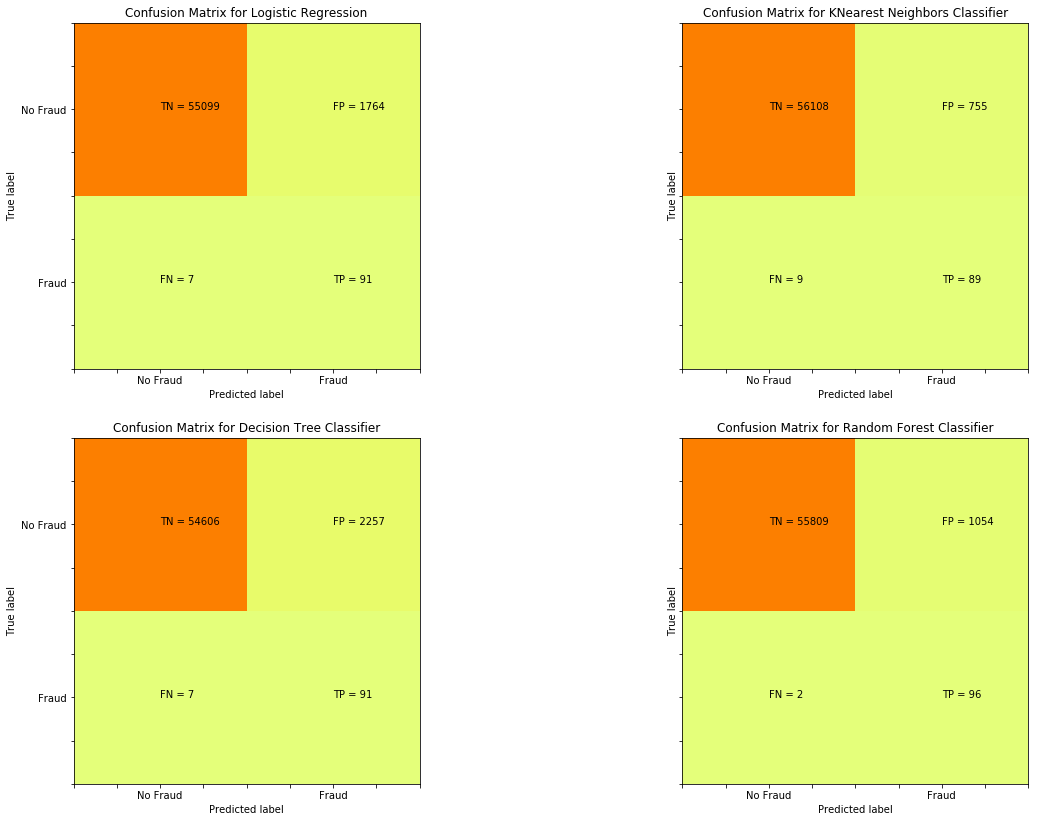

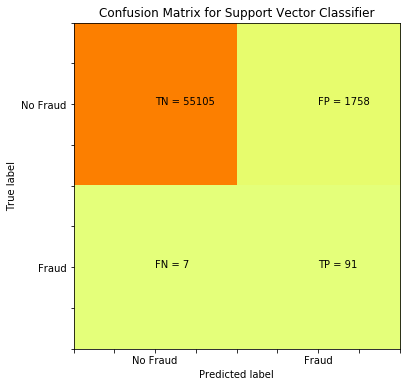

In [40]:
# Visualising the confusion matrix

from sklearn.metrics import confusion_matrix
 
cm_log = confusion_matrix(original_ytest, y_pred_log_reg)

cm_knears = confusion_matrix(original_ytest, y_pred_knears)

cm_svc = confusion_matrix(original_ytest, y_pred_svc)

cm_tree = confusion_matrix(original_ytest, y_pred_tree)

cm_forest = confusion_matrix(original_ytest, y_pred_forest)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)

# Logistic Regresiion Confusion Matrix

ax1.imshow(cm_log, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax1.set_title('Confusion Matrix for Logistic Regression')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax1.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax1.text(j,i, str(s[i][j])+" = "+str(cm_log[i][j]))
  
# KNearest Neighbors Confusion Matrix

ax2.imshow(cm_knears, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax2.set_title('Confusion Matrix for KNearest Neighbors Classifier')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax2.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax2.text(j,i, str(s[i][j])+" = "+str(cm_knears[i][j]))
        
# Decision Tree Confusion Matrix

ax3.imshow(cm_tree, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax3.set_title('Confusion Matrix for Decision Tree Classifier')
ax3.set_ylabel('True label')
ax3.set_xlabel('Predicted label')
ax3.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax3.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax3.text(j,i, str(s[i][j])+" = "+str(cm_tree[i][j]))

# Random Forest Confusion Matrix

ax4.imshow(cm_forest, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax4.set_title('Confusion Matrix for Random Forest Classifier')
ax4.set_ylabel('True label')
ax4.set_xlabel('Predicted label')
ax4.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax4.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax4.text(j,i, str(s[i][j])+" = "+str(cm_forest[i][j]))
        
# Support Vector Confusion Matrix

f,(ax5) = plt.subplots(1,1, figsize = (6, 6), sharey = True)
ax5.imshow(cm_svc, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax5.set_title('Confusion Matrix for Support Vector Classifier')
ax5.set_ylabel('True label')
ax5.set_xlabel('Predicted label')
ax5.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax5.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax5.text(j,i, str(s[i][j])+" = "+str(cm_svc[i][j]))
        



In [41]:
from sklearn.metrics import f1_score

print("Logisic Regression:", f1_score(original_ytest, y_pred_log_reg, average='weighted'))  
print("KNearsNeighbors:", f1_score(original_ytest, y_pred_knears, average='weighted')) 
print("SVC:", f1_score(original_ytest, y_pred_svc, average='weighted')) 
print("DecisionTree Classifier:", f1_score(original_ytest, y_pred_tree, average='weighted')) 
print("RandomForest Classifier:", f1_score(original_ytest, y_pred_forest, average='weighted')) 

Logisic Regression: 0.9826501902927396
KNearsNeighbors: 0.9918540005297336
SVC: 0.9827050216431841
DecisionTree Classifier: 0.978133177751019
RandomForest Classifier: 0.9891881666597983


> # Summary for the Randomly Under-Sampled Data:

* We observe that accuracy metrics can sometime be misleading and may not be the best measure of how good or bad the classifier is actually doing. This is especially the case when we have an imbalanced dataset with highly skewed or biased data. In practise, this often happens when we are dealing with outlier detection or fraud detection because the amount of data we have for fraud and outlier class is much less as compared to the genuine ones. 
* When we deal with highly biased or skewed data, using F1 score as a measure to see how our classifier is doing can be a good option.
* As we observe from our F1 scores, all of our models seem to be doing quite well on our original highly biased dataset. Decision Tree Classifier seems to be getting the highest F1 score suggesting that this might be the best classifier to use for this problem. However, other models also have their benefits. 

      * Random Forest Classifier only leaves out 2 fraud transactions as non-fraud outof the 98 fraud       transactions we had in our testing set. This shows that the Random Forest Classifier does the       best job in figuring out the fraud transactions. However, it also classifies many non-fraud         transactions as fraud ones which can be a problem as any user who made a genuine transaction        might find it annoying to get his/her card blocked because our classifier predicted it as a         fraud one. 
   
      * Decision Tree Classifier identifies most of the fraud transactions and also does a better job of    classifying the non-fraud ones.

> # SMOTE Technique (Over-Sampling)

SMOTE is an oversampling method. It works by creating synthetic samples from the minor class instead of creating copies. The algorithm selects two or more similar instances (using a distance measure) and perturbing an instance one attribute at a time by a random amount within the difference to the neighboring instances.

In [42]:
# Implementing SMOTE to create synthetic data points

print("Before OverSampling, counts of label '1': {}".format(sum(original_ytrain==1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(original_ytrain==0)))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(original_Xtrain, original_ytrain.ravel())

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, counts of label '1': 394
Before OverSampling, counts of label '0': 227452 

After OverSampling, the shape of train_X: (454904, 30)
After OverSampling, the shape of train_y: (454904,) 

After OverSampling, counts of label '1': 227452
After OverSampling, counts of label '0': 227452


In [43]:
# Training our classification algorithms for the over-sampled data:

classifiers = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier()
}

In [44]:
# First we divide the over-sampled data into cross-validation and training data:

X_training_res, X_val_res, y_training_res, y_val_res = train_test_split(X_train_res, y_train_res, test_size=0.2, random_state=42)

In [45]:
# Finding the cross_val score for our simple default classification algorithms on our over-sampled data:

from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_training_res, y_training_res)
    cross_score = cross_val_score(classifier, X_val_res, y_val_res, cv = 2)
    print("Classifiers: ", classifier.__class__.__name__, "has a Cross-Validation score of", cross_score.mean() * 100, "%")

Classifiers:  DecisionTreeClassifier has a Cross-Validation score of 98.97121326238674 %
Classifiers:  RandomForestClassifier has a Cross-Validation score of 99.74939798435535 %
Classifiers:  LogisticRegression has a Cross-Validation score of 95.15173448173088 %
Classifiers:  KNeighborsClassifier has a Cross-Validation score of 99.3262328650892 %


In [46]:
# Now we use GridSearchCv to find the best parameters for our Logisitc Regression classifier only as all the other models are already doing well with their default parameters:
"""""""""
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_log_reg_smote = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg_smote.fit(X_training_res, y_training_res)

# Logistic Regression best classifier
log_reg_smote = grid_log_reg_smote.best_estimator_
print(grid_log_reg_smote.best_params_)
"""""""

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-46-1197ec571eb8>, line 14)

* The above block of code can be run to find the best parameters. I have commented out the execution part because it takes a lot of time to get compiled. 

* Thus, the best parameters found using GridSearchCv are:
    * C = 100 
    * Penalty = l2

In [47]:
# Seeing if our best Logistic Regression model has a better cross-validation score:

log_reg_smote = LogisticRegression(C = 100, penalty = 'l2')
log_reg_smote.fit(X_training_res, y_training_res)
cross_score_log = cross_val_score(log_reg_smote, X_val_res, y_val_res, cv = 2)
print("Our best Logistic Regression model has a Cross-Validation score of", cross_score_log.mean() * 100, "%")

Our best Logistic Regression model has a Cross-Validation score of 95.1616266691023 %


In [48]:
classifiers = {
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "LogisiticRegression": LogisticRegression(C = 100, penalty = 'l2'),
    "KNearest": KNeighborsClassifier()
}

In [49]:
# Finding their cross_val score for the original testing data:

for key, classifier in classifiers.items():
    classifier.fit(X_training_res, y_training_res)
    testing_score = cross_val_score(classifier, original_Xtest, original_ytest, cv = 2)
    print("Classifiers: ", classifier.__class__.__name__, "has a testing score of", testing_score.mean() * 100, "%")

Classifiers:  DecisionTreeClassifier has a testing score of 99.81039738842256 %
Classifiers:  RandomForestClassifier has a testing score of 99.9157319397635 %
Classifiers:  LogisticRegression has a testing score of 99.87886427044404 %
Classifiers:  KNeighborsClassifier has a testing score of 99.90870952949513 %


In [50]:
# Making objects for our classifiers:
knears_smote = KNeighborsClassifier()
knears_smote.fit(X_training_res, y_training_res)

forest_clf_smote = RandomForestClassifier()
forest_clf_smote.fit(X_training_res, y_training_res)

tree_clf_smote = DecisionTreeClassifier()
tree_clf_smote.fit(X_training_res, y_training_res)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [51]:
# First, lets save all the predictions that our best classifiers make for the training set

from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict

log_reg_pred_smote = cross_val_predict(log_reg_smote, X_training_res, y_training_res, cv=2,
                             method="decision_function")

knears_pred_smote = cross_val_predict(knears_smote, X_training_res, y_training_res, cv=2)

tree_pred_smote = cross_val_predict(tree_clf_smote, X_training_res, y_training_res, cv=2)

forest_pred_smote = cross_val_predict(forest_clf_smote, X_training_res, y_training_res, cv = 2)

In [52]:
# Finding the roc_auc scores:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_training_res, log_reg_pred_smote))
print('KNears Neighbors: ', roc_auc_score(y_training_res, knears_pred_smote))
print('Decision Tree Classifier: ', roc_auc_score(y_training_res, tree_pred_smote))
print('Random Forest Classifier: ', roc_auc_score(y_training_res, forest_pred_smote))

Logistic Regression:  0.9884773217074865
KNears Neighbors:  0.997910775566232
Decision Tree Classifier:  0.9965828521708531
Random Forest Classifier:  0.9997087836777336


In [53]:
# We first find the predictions of our best classifiers on the original test dataset because ultimately that is the one that we want to do well on. Also, it is unbalanced.

y_score_log_reg_smote = cross_val_predict(log_reg_smote, original_Xtest, original_ytest, cv=2,
                             method="decision_function")

y_score_knears_smote = cross_val_predict(knears_smote, original_Xtest, original_ytest, cv=2)

y_score_tree_smote = cross_val_predict(tree_clf_smote, original_Xtest, original_ytest, cv=2)

y_score_forest_smote = cross_val_predict(forest_clf_smote, original_Xtest, original_ytest, cv = 2)

In [54]:
# Now we use precision-recall curves and classification report to see which model actually performs good:
from sklearn.metrics import average_precision_score

average_precision_log_reg_smote = average_precision_score(original_ytest, y_score_log_reg_smote)
print('Average precision-recall score for Logistic Regression: {0:0.2f}'.format(average_precision_log_reg_smote))

average_precision_knears_smote = average_precision_score(original_ytest, y_score_knears_smote)
print('Average precision-recall score for KNears Neighbors: {0:0.2f}'.format(average_precision_knears_smote))

average_precision_tree_smote = average_precision_score(original_ytest, y_score_tree_smote)
print('Average precision-recall score for Decision Tree: {0:0.2f}'.format(average_precision_tree_smote))

average_precision_forest_smote = average_precision_score(original_ytest, y_score_forest_smote)
print('Average precision-recall score for Random Forest: {0:0.2f}'.format(average_precision_forest_smote))

Average precision-recall score for Logistic Regression: 0.58
Average precision-recall score for KNears Neighbors: 0.52
Average precision-recall score for Decision Tree: 0.28
Average precision-recall score for Random Forest: 0.48


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score for Random Forest ')

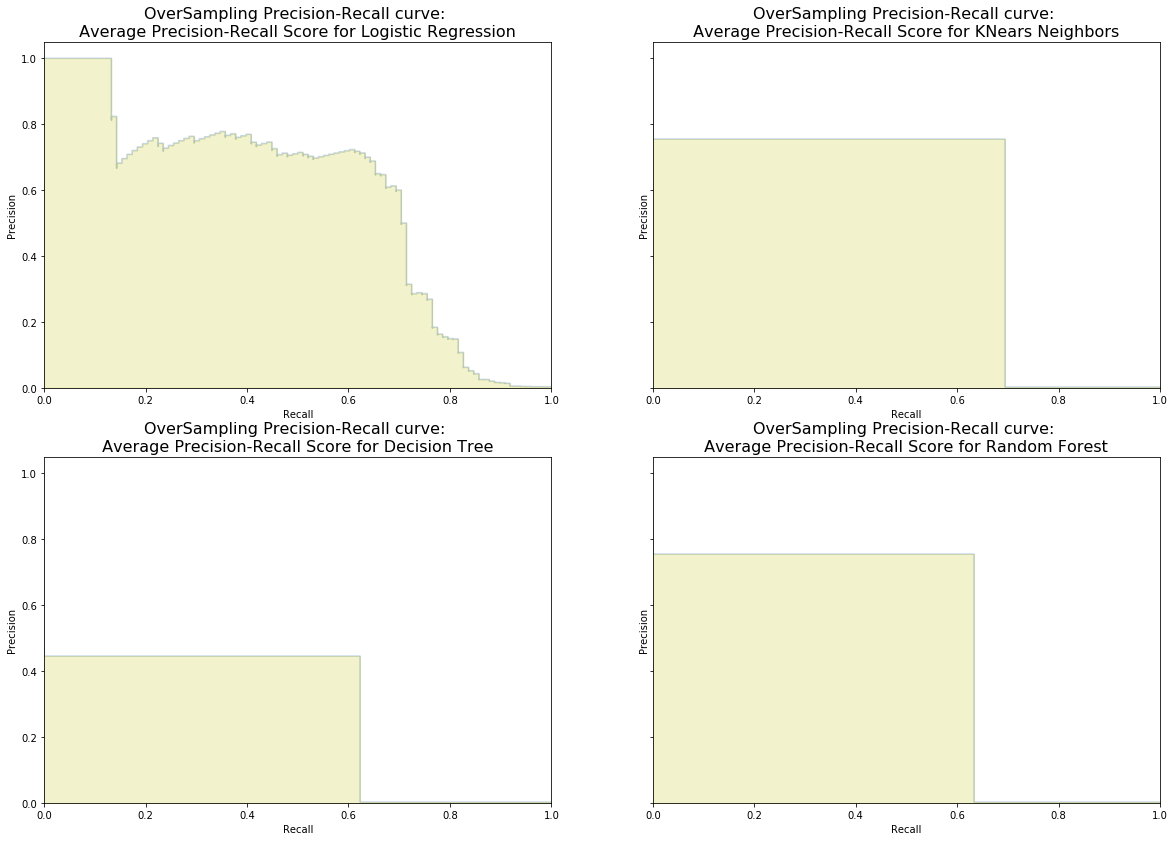

In [55]:
from sklearn.metrics import precision_recall_curve
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
precision_log_reg_smote, recall_log_reg_smote, _ = precision_recall_curve(original_ytest, y_score_log_reg_smote)

ax1.step(recall_log_reg_smote, precision_log_reg_smote, color='#004a93', alpha=0.2,
         where='post')
ax1.fill_between(recall_log_reg_smote, precision_log_reg_smote, step='post', alpha=0.2,
                 color='y')

ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_ylim([0.0, 1.05])
ax1.set_xlim([0.0, 1.0])
ax1.set_title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score for Logistic Regression ', fontsize=16)

precision_knears_smote, recall_knears_smote, _ = precision_recall_curve(original_ytest, y_score_knears_smote)

ax2.step(recall_knears_smote, precision_knears_smote, color='#004a93', alpha=0.2,
         where='post')
ax2.fill_between(recall_knears_smote, precision_knears_smote, step='post', alpha=0.2,
                 color='y')

ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_ylim([0.0, 1.05])
ax2.set_xlim([0.0, 1.0])
ax2.set_title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score for KNears Neighbors ', fontsize=16)

precision_tree_smote, recall_tree_smote, _ = precision_recall_curve(original_ytest, y_score_tree_smote)

ax3.step(recall_tree_smote, precision_tree_smote, color='#004a93', alpha=0.2,
         where='post')
ax3.fill_between(recall_tree_smote, precision_tree_smote, step='post', alpha=0.2,
                 color='y')

ax3.set_xlabel('Recall')
ax3.set_ylabel('Precision')
ax3.set_ylim([0.0, 1.05])
ax3.set_xlim([0.0, 1.0])
ax3.set_title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score for Decision Tree ', fontsize=16)

precision_forest_smote, recall_forest_smote, _ = precision_recall_curve(original_ytest, y_score_forest_smote)

ax4.step(recall_forest_smote, precision_forest_smote, color='#004a93', alpha=0.2,
         where='post')
ax4.fill_between(recall_forest_smote, precision_forest_smote, step='post', alpha=0.2,
                 color='y')

ax4.set_xlabel('Recall')
ax4.set_ylabel('Precision')
ax4.set_ylim([0.0, 1.05])
ax4.set_xlim([0.0, 1.0])
ax4.set_title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score for Random Forest ', fontsize=16)

In [56]:
# Finding predictions for all the classifiers:

y_pred_log_reg_smote = log_reg_smote.predict(original_Xtest)

y_pred_knears_smote = knears_smote.predict(original_Xtest)

y_pred_forest_smote = forest_clf_smote.predict(original_Xtest)

y_pred_tree_smote = tree_clf_smote.predict(original_Xtest)


In [57]:
# Printing the classification report for all the classifiers:
from sklearn.metrics import classification_report, accuracy_score

print("Logistic Regression:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_log_reg_smote))
print(classification_report(original_ytest, y_pred_log_reg_smote))

print("KNearestNeighbors:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_knears_smote))
print(classification_report(original_ytest, y_pred_knears_smote))

print("Random Forest Calssifier:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_forest_smote))
print(classification_report(original_ytest, y_pred_forest_smote))

print("Decision Tree Classifer:")
print("Accuracy Score :")
print(accuracy_score(original_ytest, y_pred_tree_smote))
print(classification_report(original_ytest, y_pred_tree_smote))

Logistic Regression:
Accuracy Score :
0.9755973385298713
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.06      0.92      0.11        98

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.55     56961
weighted avg       1.00      0.98      0.99     56961

KNearestNeighbors:
Accuracy Score :
0.9976650690823546
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.41      0.86      0.56        98

    accuracy                           1.00     56961
   macro avg       0.71      0.93      0.78     56961
weighted avg       1.00      1.00      1.00     56961

Random Forest Calssifier:
Accuracy Score :
0.9995611032109689
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.93      0.81      0.86        98

    accu

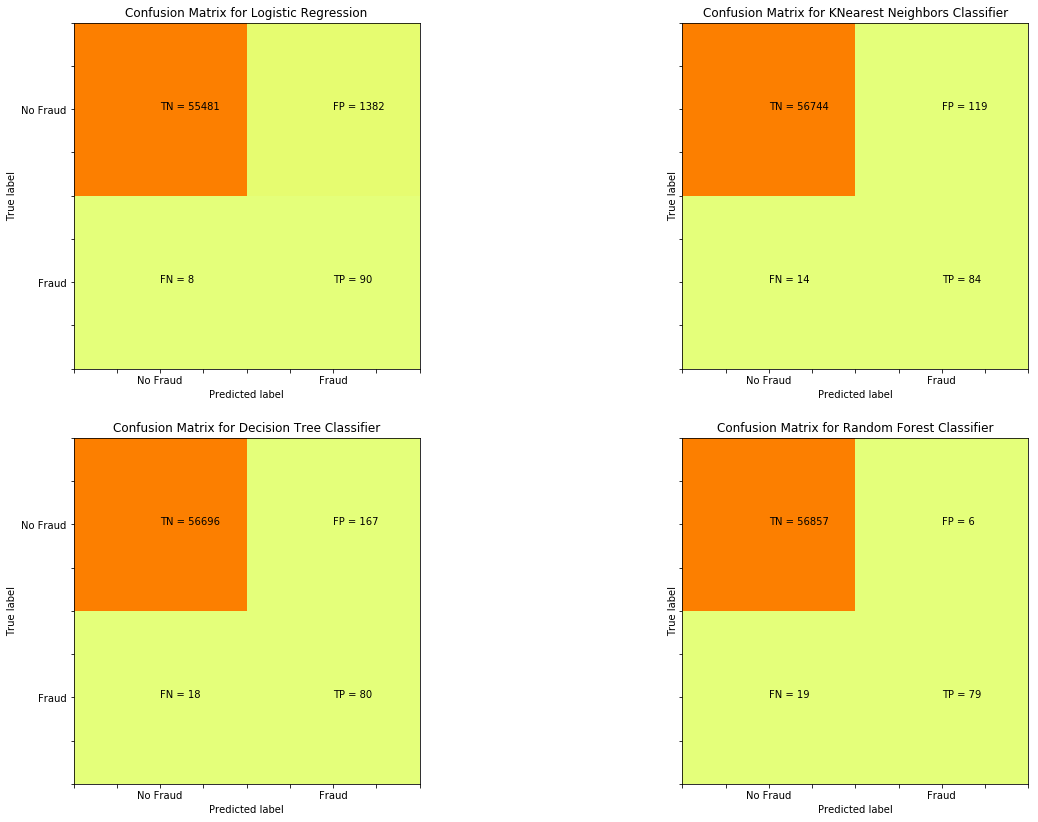

In [58]:
# Visualising the confusion matrix

from sklearn.metrics import confusion_matrix
 
cm_log_smote = confusion_matrix(original_ytest, y_pred_log_reg_smote)

cm_knears_smote = confusion_matrix(original_ytest, y_pred_knears_smote)

cm_tree_smote = confusion_matrix(original_ytest, y_pred_tree_smote)

cm_forest_smote = confusion_matrix(original_ytest, y_pred_forest_smote)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)

# Logistic Regresiion Confusion Matrix

ax1.imshow(cm_log_smote, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax1.set_title('Confusion Matrix for Logistic Regression')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax1.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax1.text(j,i, str(s[i][j])+" = "+str(cm_log_smote[i][j]))

# KNearest Neighbors Confusion Matrix  

ax2.imshow(cm_knears_smote, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax2.set_title('Confusion Matrix for KNearest Neighbors Classifier')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax2.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax2.text(j,i, str(s[i][j])+" = "+str(cm_knears_smote[i][j]))
        
# Decision Tree Confusion Matrix

ax3.imshow(cm_tree_smote, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax3.set_title('Confusion Matrix for Decision Tree Classifier')
ax3.set_ylabel('True label')
ax3.set_xlabel('Predicted label')
ax3.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax3.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax3.text(j,i, str(s[i][j])+" = "+str(cm_tree_smote[i][j]))

# Random Forest Confusion Matrix

ax4.imshow(cm_forest_smote, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax4.set_title('Confusion Matrix for Random Forest Classifier')
ax4.set_ylabel('True label')
ax4.set_xlabel('Predicted label')
ax4.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax4.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax4.text(j,i, str(s[i][j])+" = "+str(cm_forest_smote[i][j]))
        



In [59]:
# Finding the F1 scores for all our classifiers:

from sklearn.metrics import f1_score

print("Logisic Regression:", f1_score(original_ytest, y_pred_log_reg_smote, average='weighted'))  
print("KNearsNeighbors:", f1_score(original_ytest, y_pred_knears_smote, average='weighted')) 
print("DecisionTree Classifier:", f1_score(original_ytest, y_pred_tree_smote, average='weighted')) 
print("RandomForest Classifier:", f1_score(original_ytest, y_pred_forest_smote, average='weighted')) 

Logisic Regression: 0.9861262305898227
KNearsNeighbors: 0.9980712455910181
DecisionTree Classifier: 0.9974513777140392
RandomForest Classifier: 0.9995455390629995


> # Summary for the Over-Sampled Data::

* We observe that by creating synthetic data points to train our data using the SMOTE technique, we managed to solve the problem of the high biased and skewed nature of our original dataset. All of our classification models seem to be doing quite well on the original dataset. 

* The best classifier according to the F1 score is the Random Forest Classifier. We observe that:

      * Logistic Regression seems to be doing the best job in identifying the fraud transactions. It only   leaves out 6 of the 98 that we have in our original dataset. However, Logistic Regression also      classifies many of the non-fraud transactions as fraud ones which is undesirable and thus it has a  comparitively small F1 score. 
      
      * The Random Forest Classifier does a good job in idenifying the fraud transactions but what sets it  apart is its ability to more correctly identify the non-fraud transactions, thus giving the best    F1 score.      

> # Neural Networks: Comparing under-sampling and over-sampling using Neaural Networks

Here, we will implement a simple neural network to compare which of the two i.e. Under-Sampling and Over-Sampling technique that we have implemented is better.

**Goal: **
We try to figure out which of the two techniques that we have implemented to take care of our skewed dataset is better. The main reason for doing is that in a real life situation, we want to predict both the fraud as well as the non-fraud cases. If our model predicts the non-fraud cases as fraud ones very often, then this can be a problem as well because this can upset a genuine user who made a transaction by classifying it as non-fraud and then blocking his/her card.

> # Neural Network Architecture:

We use a simple neural network architecture with two hidden layers and also implement Dropout to prevent over-fitting. We use the cross-entropy loss for the optimizer and also use the AdamOptimizer and relu activation function at the two hidden layers and a softmax function at the output layer. We set the learning rate to be 0.001

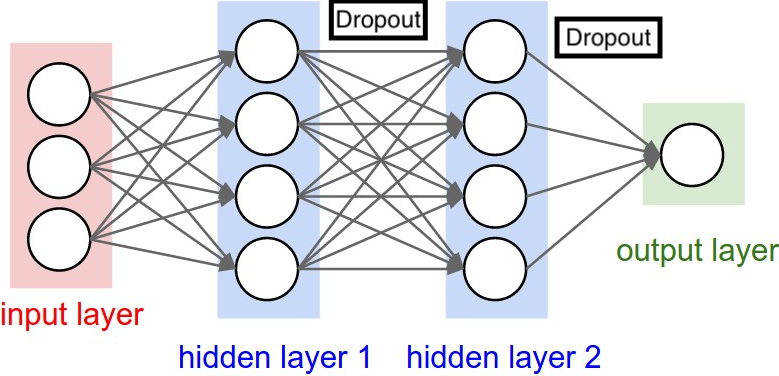

In [60]:
# Importing the required libraries and functions:
import keras
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.layers import Dropout

In [61]:
# Building the first Neural Network model which trains on the randomly Under-Sampled data

input_size = X_train.shape[1]

undersample_NN = Sequential()
undersample_NN.add(Dense(input_size, input_shape = (input_size, ), activation = 'relu'))
undersample_NN.add(Dense(32, activation = 'relu'))
undersample_NN.add(Dropout(0.4))
undersample_NN.add(Dense(64, activation = 'relu'))
#undersample_NN.add(Dropout(0.4))
undersample_NN.add(Dense(2, activation = 'softmax'))

In [62]:
# Getting the summary of our under sample model architecture:
undersample_NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 130       
Total params: 4,164
Trainable params: 4,164
Non-trainable params: 0
_________________________________________________________________


In [63]:
# Compiling the undersample Neaural Network model

undersample_NN.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [64]:
# Fitting the model

undersample_NN.fit(X_train, y_train, validation_split = 0.2, batch_size = 25, epochs = 10, shuffle = True, verbose = 2)

Train on 608 samples, validate on 152 samples
Epoch 1/10
 - 2s - loss: 0.5065 - acc: 0.7270 - val_loss: 0.3694 - val_acc: 0.8158
Epoch 2/10
 - 0s - loss: 0.3403 - acc: 0.8750 - val_loss: 0.3132 - val_acc: 0.8750
Epoch 3/10
 - 0s - loss: 0.2985 - acc: 0.9062 - val_loss: 0.2676 - val_acc: 0.8816
Epoch 4/10
 - 0s - loss: 0.2395 - acc: 0.9243 - val_loss: 0.2418 - val_acc: 0.9013
Epoch 5/10
 - 0s - loss: 0.2031 - acc: 0.9342 - val_loss: 0.2055 - val_acc: 0.9013
Epoch 6/10
 - 0s - loss: 0.1671 - acc: 0.9408 - val_loss: 0.2096 - val_acc: 0.9145
Epoch 7/10
 - 0s - loss: 0.1651 - acc: 0.9424 - val_loss: 0.1916 - val_acc: 0.9145
Epoch 8/10
 - 0s - loss: 0.1670 - acc: 0.9408 - val_loss: 0.1889 - val_acc: 0.9211
Epoch 9/10
 - 0s - loss: 0.1493 - acc: 0.9523 - val_loss: 0.1944 - val_acc: 0.9276
Epoch 10/10
 - 0s - loss: 0.1258 - acc: 0.9622 - val_loss: 0.1829 - val_acc: 0.9276


In [65]:
# Predicitng the outcomes for the original test dataset

undersample_predictions_original = undersample_NN.predict(original_Xtest, batch_size = 200, verbose = 0)

In [66]:
# Predicitng the classes of transactions for the original test dataset

undersample_predictions = undersample_NN.predict_classes(original_Xtest, batch_size = 200, verbose = 0)

In [67]:
# Building the second Neural Network which trains on the Over-Sampled data

input_size = X_train_res.shape[1]

oversample_NN = Sequential()
oversample_NN.add(Dense(input_size, input_shape = (input_size, ), activation = 'relu'))
oversample_NN.add(Dense(32, activation = 'relu'))
oversample_NN.add(Dropout(0.4))
oversample_NN.add(Dense(64, activation = 'relu'))
oversample_NN.add(Dropout(0.4))
oversample_NN.add(Dense(2, activation = 'softmax'))

In [68]:
# Getting the summary of our over sampled model architecture:
oversample_NN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                992       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 130       
Total params: 4,164
Trainable params: 4,164
Non-trainable params: 0
_________________________________________________________________


In [69]:
# Compiling the over-sampled Neural Network model:

oversample_NN.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
# Fitting the model

oversample_NN.fit(X_train_res, y_train_res, validation_split = 0.2, batch_size = 25, epochs = 5, shuffle = True, verbose = 2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/5
 - 51s - loss: 0.0326 - acc: 0.9890 - val_loss: 0.0078 - val_acc: 0.9986
Epoch 2/5
 - 50s - loss: 0.0098 - acc: 0.9976 - val_loss: 0.0019 - val_acc: 1.0000
Epoch 3/5
 - 51s - loss: 0.0075 - acc: 0.9982 - val_loss: 0.0030 - val_acc: 0.9999
Epoch 4/5
 - 50s - loss: 0.0068 - acc: 0.9986 - val_loss: 0.0019 - val_acc: 0.9995
Epoch 5/5
 - 50s - loss: 0.0060 - acc: 0.9987 - val_loss: 0.0011 - val_acc: 1.0000


In [71]:
# Predicitng the outcomes for the original test dataset

oversample_predictions_original = oversample_NN.predict(original_Xtest, batch_size = 200, verbose = 0)

In [72]:
# Predicting the classes of transactions for the original test dataset

oversample_predictions = oversample_NN.predict_classes(original_Xtest, batch_size = 200, verbose = 0)

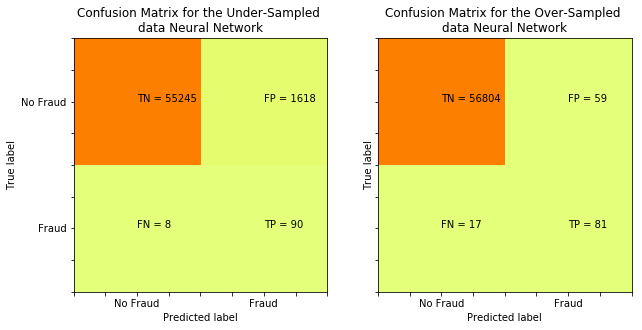

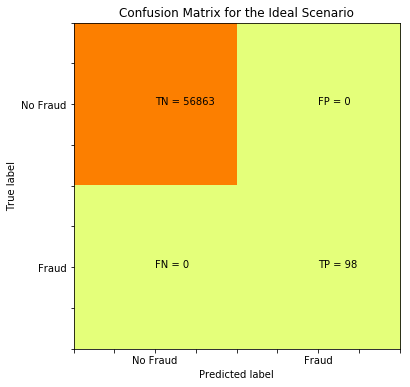

In [73]:
# Visualising the performance of our Neural Networks by making the confusion matrix:

cm_undersample_NN = confusion_matrix(original_ytest, undersample_predictions)
cm_oversample_NN = confusion_matrix(original_ytest, oversample_predictions)
cm_ideal = confusion_matrix(original_ytest, original_ytest)
f, ((ax1, ax2)) = plt.subplots(1,2, figsize=(10,7), sharey=True)

# Under-Sampled Data Neural Network Confusion Matrix

ax1.imshow(cm_undersample_NN, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax1.set_title('Confusion Matrix for the Under-Sampled \ndata Neural Network')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax1.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax1.text(j,i, str(s[i][j])+" = "+str(cm_undersample_NN[i][j]))
        
        
# Over-Sampled Data Neural Network Confusion Matrix

ax2.imshow(cm_oversample_NN, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax2.set_title('Confusion Matrix for the Over-Sampled \ndata Neural Network')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax2.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax2.text(j,i, str(s[i][j])+" = "+str(cm_oversample_NN[i][j]))
        
f,(ax5) = plt.subplots(1,1, figsize = (6, 6), sharey = True)
ax5.imshow(cm_ideal, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax5.set_title('Confusion Matrix for the Ideal Scenario')
ax5.set_ylabel('True label')
ax5.set_xlabel('Predicted label')
ax5.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax5.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax5.text(j,i, str(s[i][j])+" = "+str(cm_ideal[i][j]))
        



In [74]:
# Now let us also print the classification report for both our Neural Networks:

from sklearn.metrics import classification_report, accuracy_score

# Classification report for the Under-Sampled data Neural Network

print("Under-Sampled Data Neural Network:")
print("Accuracy Score:", accuracy_score(original_ytest, undersample_predictions))
print(classification_report(original_ytest, undersample_predictions))

# Classification report for the Over-Sampled data Neural Network
print("Over-Sampled Data Neural Network:")
print("Accuracy Score:", accuracy_score(original_ytest, oversample_predictions))
print(classification_report(original_ytest, oversample_predictions))

Under-Sampled Data Neural Network:
Accuracy Score: 0.9714541528414178
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     56863
           1       0.05      0.92      0.10        98

    accuracy                           0.97     56961
   macro avg       0.53      0.94      0.54     56961
weighted avg       1.00      0.97      0.98     56961

Over-Sampled Data Neural Network:
Accuracy Score: 0.9986657537613455
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.58      0.83      0.68        98

    accuracy                           1.00     56961
   macro avg       0.79      0.91      0.84     56961
weighted avg       1.00      1.00      1.00     56961



In [75]:
# Finding the F1 score of both the neural networks:

from sklearn.metrics import f1_score

# F1 score of the under-sampled Neural Network:
print("Undersampled Neural Network F1 score:", f1_score(original_ytest, undersample_predictions, average='weighted'))  

# F1 score of the over-sampled Neural Network:
print("Oversampled Neural Network F1 score:", f1_score(original_ytest, y_pred_knears_smote, average='weighted')) 

Undersampled Neural Network F1 score: 0.98397311596707
Oversampled Neural Network F1 score: 0.9980712455910181


> # Summary of Neural Networks using the under-sampled and over-sampled data:

* We can see that our over-sampled Neural Network has a higher F1 score as compared to our under-sampled Neural Network. This shows us that our over-sampled Neural Network is able to better gneralize over the data given to us.
* However, on seeing the confusion matrix of both the Neural Netwoks, we see that the under-sampled Neural Network is able to better identify the fraud transactions but then it also classifies a large number of non-fraud transactions as fraud ones which is not desirable.

> # Isolation Forest Algorithm

* One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

* This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

* Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

**How Isolation Forests Work**

* The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

* The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

In [76]:
# Finding the outlier fraction and the number of fraud and non-fraud cases:

Fraud = df[df['Class']==1]

Valid = df[df['Class']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))

0.0017304750013189597
Fraud Cases : 492
Valid Cases : 284315


In [77]:
# Creating the Isolated Forest algorithm object:

from sklearn.ensemble import IsolationForest

isolated_forest_model = IsolationForest(n_estimators = 100, max_samples = len(X), 
                                       contamination = outlier_fraction, random_state = 42, verbose = 0)

In [78]:
# Fitting the Isolated Forest model:

isolated_forest_model.fit(original_Xtrain, original_ytrain)

IsolationForest(behaviour='old', bootstrap=False,
                contamination=0.0017304750013189597, max_features=1.0,
                max_samples=951, n_estimators=100, n_jobs=None, random_state=42,
                verbose=0, warm_start=False)

In [79]:
# Making predictions for the original testing data

scores_prediction_iso = isolated_forest_model.decision_function(original_Xtest)

y_pred_iso = isolated_forest_model.predict(original_Xtest)

In [80]:
# Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
y_pred_iso[y_pred_iso == 1] = 0
y_pred_iso[y_pred_iso == -1] = 1
n_errors = (y_pred_iso != original_ytest).sum()

In [81]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Number of errors for Isolated Forest Algorithm:", n_errors)
print("Accuracy Score :")
print(accuracy_score(original_ytest,y_pred_iso))
print("Classification Report for Isolation Forest:")
print(classification_report(original_ytest,y_pred_iso))

Number of errors for Isolated Forest Algorithm: 124
Accuracy Score :
0.9978230719264057
Classification Report for Isolation Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.36      0.35      0.35        98

    accuracy                           1.00     56961
   macro avg       0.68      0.67      0.68     56961
weighted avg       1.00      1.00      1.00     56961



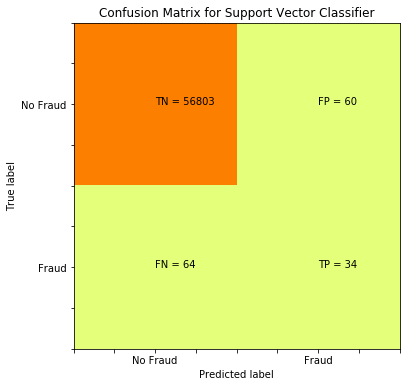

In [82]:
# Now let us plot the confusion matrix for the Isolated Forest model:

from sklearn.metrics import confusion_matrix
 
cm_iso = confusion_matrix(original_ytest, y_pred_iso)

f,(ax1) = plt.subplots(1,1, figsize = (6, 6), sharey = True)
ax1.imshow(cm_iso, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax1.set_title('Confusion Matrix for Support Vector Classifier')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax1.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax1.text(j,i, str(s[i][j])+" = "+str(cm_iso[i][j]))


> # Summary for the Isolated Forest Algorithm:

* This experiment serves a true reminder as to why we should not trust accuracy as a measure when we are dealing with skewed datasets. 
* Our Isolated Forest Algorithm has a high accuracy -99.76%. However, when we plot the confusion matrix, we are able to see the true performance of our classifier. It classified only 36 out of the 98 fraud transactions correctly. Although, it did good on the non-fraud part of the dataset but still it was unable to perform good for the main aim we had for this project i.e. fraud transaction detection.

> # Boosting Algorithms

* The term ‘Boosting’ refers to a family of algorithms which converts weak learner to strong learners.

* For choosing the right distribution, here are the following steps:

* **Step 1**:  The base learner takes all the distributions and assign equal weight or attention to each observation.

* **Step 2**: If there is any prediction error caused by first base learning algorithm, then we pay higher attention to observations having prediction error. Then, we apply the next base learning algorithm.

* **Step 3**: Iterate Step 2 till the limit of base learning algorithm is reached or higher accuracy is achieved.

* Finally, it combines the outputs from weak learner and creates  a strong learner which eventually improves the prediction power of the model. Boosting pays higher focus on examples which are mis-classiﬁed or have higher errors by preceding weak rules.


We try three Boosting Algorithms:

1. XGB Classifier
2. GBM Classifier
3. AdaBoost Classifier

In [83]:
# Building the XGBClassifier:

import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier()

In [84]:
# Training the model

xgb.fit(original_Xtrain, original_ytrain)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [85]:
# Predicitng for the original testing dataset

xgb_pred = xgb.predict(original_Xtest)

In [86]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, xgb_pred))
print("Classification Report for XGBClassifier:")
print(classification_report(original_ytest, xgb_pred))

Accuracy Score :
0.9995962149540913
Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.94      0.82      0.87        98

    accuracy                           1.00     56961
   macro avg       0.97      0.91      0.94     56961
weighted avg       1.00      1.00      1.00     56961



In [87]:
# Building the GBM Classifier:

from sklearn.ensemble import GradientBoostingClassifier
gbm = GradientBoostingClassifier()

In [88]:
# Training the model

gbm.fit(original_Xtrain, original_ytrain)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [89]:
# Predicitng for the original testing dataset

gbm_pred = gbm.predict(original_Xtest)

In [90]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, gbm_pred))
print("Classification Report for GBMClassifier:")
print(classification_report(original_ytest, gbm_pred))

Accuracy Score :
0.9988237566053967
Classification Report for GBMClassifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.40      0.54        98

    accuracy                           1.00     56961
   macro avg       0.91      0.70      0.77     56961
weighted avg       1.00      1.00      1.00     56961



In [91]:
# Building the AdaBoost Classifier:

from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier()

In [92]:
# Training the model

ada_model.fit(original_Xtrain, original_ytrain)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [93]:
# Predicitng for the original testing dataset

ada_pred = ada_model.predict(original_Xtest)

In [94]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, ada_pred))
print("Classification Report for AdaBoost Classifier:")
print(classification_report(original_ytest, ada_pred))

Accuracy Score :
0.9991924299081828
Classification Report for AdaBoost Classifier:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.78      0.73      0.76        98

    accuracy                           1.00     56961
   macro avg       0.89      0.87      0.88     56961
weighted avg       1.00      1.00      1.00     56961



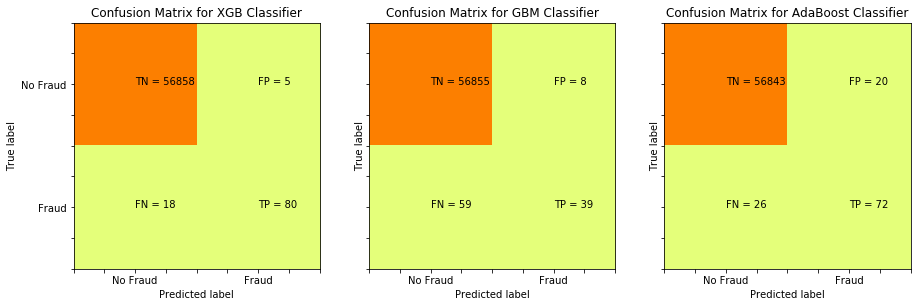

In [95]:
# Printing the confusion matrix for our Boosting Algorithms

from sklearn.metrics import confusion_matrix

cm_xgb = confusion_matrix(original_ytest, xgb_pred)
cm_gbm = confusion_matrix(original_ytest, gbm_pred)
cm_ada = confusion_matrix(original_ytest, ada_pred)

f, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(15,10), sharey=True)

# XGB Classifier

ax1.imshow(cm_xgb, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax1.set_title('Confusion Matrix for XGB Classifier')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax1.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax1.text(j,i, str(s[i][j])+" = "+str(cm_xgb[i][j]))
        
        
# Gradient Boosting Machine

ax2.imshow(cm_gbm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax2.set_title('Confusion Matrix for GBM Classifier')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax2.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax2.text(j,i, str(s[i][j])+" = "+str(cm_gbm[i][j]))
        

# AdaBoost Classifier

ax3.imshow(cm_ada, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax3.set_title('Confusion Matrix for AdaBoost Classifier')
ax3.set_ylabel('True label')
ax3.set_xlabel('Predicted label')
ax3.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax3.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax3.text(j,i, str(s[i][j])+" = "+str(cm_ada[i][j]))
        

In [96]:
# Finding the F1 score of our boosting algorithms:

from sklearn.metrics import f1_score

# F1 score of the XGB Classifier:
print("XGB Classifier F1 score:", f1_score(original_ytest, xgb_pred, average='weighted'))  

# F1 score of the GBM Classifier:
print("GBM Classifier F1 score:", f1_score(original_ytest, gbm_pred, average='weighted')) 

# F1 score of the AdaBoost Classifier:
print("AdaBoost Classifier F1 score:", f1_score(original_ytest, ada_pred, average = 'weighted'))

XGB Classifier F1 score: 0.9995818959379594
GBM Classifier F1 score: 0.9986171636311729
AdaBoost Classifier F1 score: 0.9991797001033926


# Now let us perform an experiment: We will try to train the boosting algorithms using our randomly Under-Sampled data.

In [97]:
# XGB Classifier on the under-Sampled Data:

xgb_under = XGBClassifier()
xgb_under.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [98]:
# Predicting using our XGB Classifier on the original dataset

xgb_under_pred = xgb_under.predict(original_Xtest)

In [99]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, xgb_under_pred))
print("Classification Report for XGB Classifier:")
print(classification_report(original_ytest, xgb_under_pred))

Accuracy Score :
0.9639226839416443
Classification Report for XGB Classifier:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.98      0.09        98

    accuracy                           0.96     56961
   macro avg       0.52      0.97      0.53     56961
weighted avg       1.00      0.96      0.98     56961



In [100]:
# GBM Classifier on the randomly Under-Sampled Data:

gbm_under = GradientBoostingClassifier()
gbm_under.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [101]:
# Predicitng using the GBM Classifier on the original dataset

gbm_under_pred = gbm_under.predict(original_Xtest)

In [102]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, gbm_under_pred))
print("Classification Report for GBM Classifier:")
print(classification_report(original_ytest, gbm_under_pred))

Accuracy Score :
0.9602183950422218
Classification Report for GBM Classifier:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     56863
           1       0.04      0.98      0.08        98

    accuracy                           0.96     56961
   macro avg       0.52      0.97      0.53     56961
weighted avg       1.00      0.96      0.98     56961



In [103]:
# AdaBoost Classifier on the randomly Under-Sampled Data:

ada_under = AdaBoostClassifier()
ada_under.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [104]:
# Predicitng using the AdaBoost Classifier on the original dataset

ada_under_pred = ada_under.predict(original_Xtest)

In [105]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, ada_under_pred))
print("Classification Report for AdaBoost Classifier:")
print(classification_report(original_ytest, ada_under_pred))

Accuracy Score :
0.9546531837573077
Classification Report for AdaBoost Classifier:
              precision    recall  f1-score   support

           0       1.00      0.95      0.98     56863
           1       0.04      0.97      0.07        98

    accuracy                           0.95     56961
   macro avg       0.52      0.96      0.52     56961
weighted avg       1.00      0.95      0.98     56961



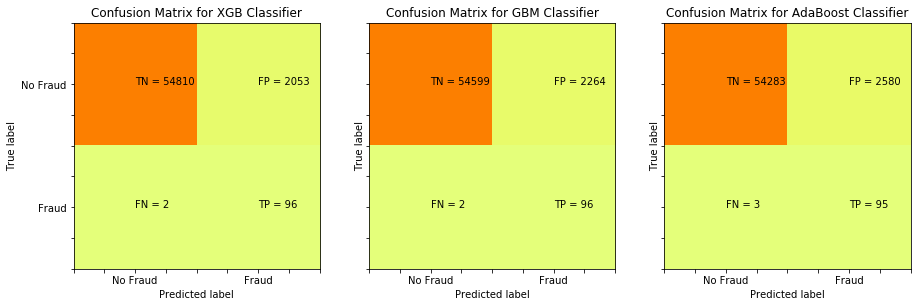

In [106]:
# Printing the confusion matrix for our Boosting Algorithms on our Randomly Under-Sampled Data:

from sklearn.metrics import confusion_matrix

cm_xgb_under = confusion_matrix(original_ytest, xgb_under_pred)
cm_gbm_under = confusion_matrix(original_ytest, gbm_under_pred)
cm_ada_under = confusion_matrix(original_ytest, ada_under_pred)

f, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(15,10), sharey=True)

# XGB Classifier

ax1.imshow(cm_xgb_under, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax1.set_title('Confusion Matrix for XGB Classifier')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax1.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax1.text(j,i, str(s[i][j])+" = "+str(cm_xgb_under[i][j]))
        
        
# Gradient Boosting Machine

ax2.imshow(cm_gbm_under, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax2.set_title('Confusion Matrix for GBM Classifier')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax2.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax2.text(j,i, str(s[i][j])+" = "+str(cm_gbm_under[i][j]))
        

# AdaBoost Classifier

ax3.imshow(cm_ada_under, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax3.set_title('Confusion Matrix for AdaBoost Classifier')
ax3.set_ylabel('True label')
ax3.set_xlabel('Predicted label')
ax3.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax3.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax3.text(j,i, str(s[i][j])+" = "+str(cm_ada_under[i][j]))
        

In [107]:
# Finding the F1 score of our boosting algorithms on the Randomly Under-Sampled Data:

from sklearn.metrics import f1_score

# F1 score of the under-sampled XGB Classifier:
print("XGB Classifier F1 score on the under-sampled data:", f1_score(original_ytest, xgb_under_pred, average='weighted'))  

# F1 score of the under-sampled GBM Classifier:
print("GBM Classifier F1 score on the under-sampled data:", f1_score(original_ytest, gbm_under_pred, average='weighted')) 

# F1 score of the under-sampled AdaBoost classifier:
print("AdaBoost Classifier F1 score on the under-sampled data:", f1_score(original_ytest, ada_under_pred, average = 'weighted'))

XGB Classifier F1 score on the under-sampled data: 0.9800565822028102
GBM Classifier F1 score on the under-sampled data: 0.9781194574275858
AdaBoost Classifier F1 score on the under-sampled data: 0.975198314647198


# Now let us perform an experiment: We will try to train the boosting algorithms using our Over-Sampled data.

In [108]:
# XGB Classifier on the Over-Sampled Data:

xgb_over = XGBClassifier()
xgb_over.fit(X_train_res, y_train_res)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [109]:
# Predicting using our XGB Classifier on the original dataset

xgb_over_pred = xgb_over.predict(original_Xtest)

In [110]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, xgb_over_pred))
print("Classification Report for XGB Classifier:")
print(classification_report(original_ytest, xgb_over_pred))

Accuracy Score :
0.9885009041273854
Classification Report for XGB Classifier:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.12      0.92      0.22        98

    accuracy                           0.99     56961
   macro avg       0.56      0.95      0.60     56961
weighted avg       1.00      0.99      0.99     56961



In [111]:
# GBM Classifier on the randomly Over-Sampled Data:

gbm_over = GradientBoostingClassifier()
gbm_over.fit(X_train_res, y_train_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [112]:
# Predicitng using the GBM Classifier on the original dataset

gbm_over_pred = gbm_over.predict(original_Xtest)

In [113]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, gbm_over_pred))
print("Classification Report for GBM Classifier:")
print(classification_report(original_ytest, gbm_over_pred))

Accuracy Score :
0.987026210916241
Classification Report for GBM Classifier:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56863
           1       0.11      0.90      0.19        98

    accuracy                           0.99     56961
   macro avg       0.55      0.94      0.59     56961
weighted avg       1.00      0.99      0.99     56961



In [114]:
# AdaBoost Classifier on the randomly Over-Sampled Data:

ada_over = AdaBoostClassifier()
ada_over.fit(X_train_res, y_train_res)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)

In [115]:
# Predicitng using the AdaBoost Classifier on the original dataset

ada_over_pred = ada_over.predict(original_Xtest)

In [116]:
# Printing the accuracy score and the classification report

from sklearn.metrics import classification_report,accuracy_score

print("Accuracy Score :")
print(accuracy_score(original_ytest, ada_over_pred))
print("Classification Report for AdaBoost Classifier:")
print(classification_report(original_ytest, ada_over_pred))

Accuracy Score :
0.9771773669703833
Classification Report for AdaBoost Classifier:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56863
           1       0.07      0.92      0.12        98

    accuracy                           0.98     56961
   macro avg       0.53      0.95      0.56     56961
weighted avg       1.00      0.98      0.99     56961



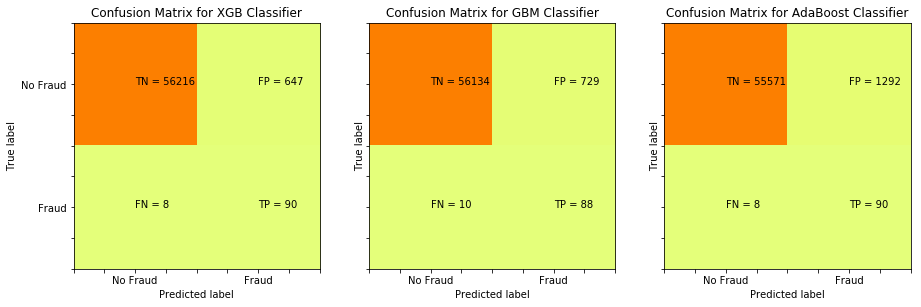

In [117]:
# Printing the confusion matrix for our Boosting Algorithms on our Randomly Over-Sampled Data:

from sklearn.metrics import confusion_matrix

cm_xgb_over = confusion_matrix(original_ytest, xgb_over_pred)
cm_gbm_over = confusion_matrix(original_ytest, gbm_over_pred)
cm_ada_over = confusion_matrix(original_ytest, ada_over_pred)

f, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(15,10), sharey=True)

# XGB Classifier

ax1.imshow(cm_xgb_over, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax1.set_title('Confusion Matrix for XGB Classifier')
ax1.set_ylabel('True label')
ax1.set_xlabel('Predicted label')
ax1.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax1.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax1.text(j,i, str(s[i][j])+" = "+str(cm_xgb_over[i][j]))
        
        
# Gradient Boosting Machine

ax2.imshow(cm_gbm_over, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax2.set_title('Confusion Matrix for GBM Classifier')
ax2.set_ylabel('True label')
ax2.set_xlabel('Predicted label')
ax2.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax2.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax2.text(j,i, str(s[i][j])+" = "+str(cm_gbm_over[i][j]))
        

# AdaBoost Classifier

ax3.imshow(cm_ada_over, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
ax3.set_title('Confusion Matrix for AdaBoost Classifier')
ax3.set_ylabel('True label')
ax3.set_xlabel('Predicted label')
ax3.xaxis.set_ticklabels(['','','No Fraud','','','','Fraud'])
ax3.yaxis.set_ticklabels(['','','No Fraud','','','', 'Fraud'])
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        ax3.text(j,i, str(s[i][j])+" = "+str(cm_ada_over[i][j]))
        

In [118]:
# Finding the F1 score of our boosting algorithms on the Over-Sampled Data:

from sklearn.metrics import f1_score

# F1 score of the over-sampled XGB Classifier:
print("XGB Classifier F1 score on the over-sampled data:", f1_score(original_ytest, xgb_over_pred, average='weighted'))  

# F1 score of the over-sampled GBM Classifier:
print("GBM Classifier F1 score on the over-sampled data:", f1_score(original_ytest, gbm_over_pred, average='weighted')) 

# F1 score of the over-sampled AdaBoost classifier:
print("AdaBoost Classifier F1 score on the over-sampled data:", f1_score(original_ytest, ada_over_pred, average = 'weighted'))

XGB Classifier F1 score on the over-sampled data: 0.9928683696605004
GBM Classifier F1 score on the over-sampled data: 0.9920822905581823
AdaBoost Classifier F1 score on the over-sampled data: 0.9869471467415347


> # Summary for the Boosting Algorithms:

* We observe that our boosting algorithms do a decent job given the time they take to get executed.
* The Boosting algorithms that are trained on the original dataset do a great job in identifying the non-fraud transactions, especially the XGB Algorithm. However, they leave quite a fraud transactions as non-fraud ones which is a major issue.

* The Boosting algorithms that are trained on the randomly under-sampled dataset are able to an exellent job in identifying the fraud transactions. However, they classify many of the non-fraud transactions as fraud ones.

* The Boosting algorithms that are trained on the over-sampled dataset do a decent job in identifying the fraud transactions but classify many of the non-fraud transactions as fraud ones. Hence, they might not be the classifier to use for the given problem.